In [1]:
import datetime

import fastai.callback.progress
import pandas as pd
import numpy as np

import torch
torch.cuda.empty_cache()

import matplotlib as plt
from fastai.vision.all import *

from scclib.util.callbacks import LearningRateScheduler, ConsoleBar

In [2]:
model_path = Path('../models')
path = Path('../data')

In [3]:
cell_df = pd.read_csv(path/'cells_sample.csv')
cell_df = cell_df.iloc[:100,:]
cell_df

,image_id,image_labels
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0
1,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0
2,2533bcc2-bba5-11e8-b2ba-ac1f6b6435d0,0
3,280f88c2-bba5-11e8-b2ba-ac1f6b6435d0,0
4,13669cc6-bbaa-11e8-b2ba-ac1f6b6435d0,0
...,...,...
95,5d9c80f4-bbb8-11e8-b2ba-ac1f6b6435d0,0
96,91bb7fae-bbbb-11e8-b2ba-ac1f6b6435d0,0
97,8768a5ec-bba0-11e8-b2b9-ac1f6b6435d0,0
98,9bf68f5e-bbca-11e8-b2bc-ac1f6b6435d0,0


In [4]:
def get_x(r): return path/'train'/f"{r['image_id']}.png"
def get_y(r): return r['image_labels'].split('|')

In [5]:
def get_dls(bs: int, size: int):
    return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     splitter=RandomSplitter(seed=42),
                     get_x=get_x,
                     get_y=get_y,
                     batch_tfms=aug_transforms(size=size, min_scale=0.75))\
        .dataloaders(cell_df, bs=bs, num_workers=0)

In [6]:
batch_size = 4
image_size = 256

dls = get_dls(batch_size, image_size)

In [7]:
lr_manipulator = lambda lr: lr*2
lr_sched = LearningRateScheduler(lr_manipulator)

cbs = [lr_sched]

learn = cnn_learner(dls,
                    resnet18,
                    metrics=partial(accuracy_multi, thresh=0.2),
                    cbs=cbs).to_fp16()

In [8]:
import fastprogress

# fastprogress.fastprogress.master_bar, fastprogress.fastprogress.progress_bar = fastprogress.fastprogress.force_console_behavior()
fastai.callback.training.master_bar, fastai.callback.training.progress_bar = fastprogress.fastprogress.force_console_behavior()

In [9]:
# with learn.no_bar():
learn.fine_tune(4, base_lr=0.03)

[]

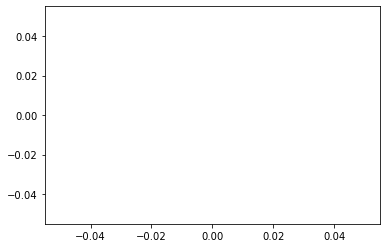

In [10]:
plt.plot(data=lr_sched.lr_history)